# Modelling

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import os

In [15]:
base_dir = os.path.abspath("..")
data_dir = os.path.join(base_dir, "data")
results_dir = os.path.join(data_dir, "results")

In [16]:
data = pd.read_csv(os.path.join(data_dir, "final_final_dataset.csv"))

In [17]:
numeric_features = [
    "rooms", "floors", "area", "metres_cadastre", "emissions_de_co2",
    "renda_med", "gini", "pct_65_plus", "pct_under18", "pct_single_household",
    "ingresos_otros_prest","ingresos_otros","ingresos_pensiones",
    "ingresos_desempleo","ingresos_salario",
    "renta_bruta_hogar","renta_bruta_persona","renta_neta_hogar","renta_neta_persona",
    "edad_media","poblacion","pct_espanola","tamany_mitja_hogar",
    "education_count_within_500m","food_count_within_500m","health_count_within_500m",
    "mobility_count_within_500m","public_service_count_within_500m"
]

categorical_features = ["elevator", "qual_energia", "sector_oficial"]

target = "price"

In [18]:
X = data[numeric_features + categorical_features]
y = data[target]


In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop='first'), categorical_features)
    ]
)

In [20]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regressor", ElasticNetCV(cv=5, l1_ratio=0.5, random_state=42, n_alphas=100))
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model.fit(X_train, y_train)

c:\Users\AlbertTR\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preproc', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

# Results

In [23]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mae = np.mean(np.abs(y_train - y_train_pred))
train_r2 = model.score(X_train, y_train)
test_mae = np.mean(np.abs(y_test - y_test_pred))
test_r2 = model.score(X_test, y_test)

print(f"Train R²: {train_r2:.3f}, MAE: {train_mae:.2f}")
print(f"Test R²: {test_r2:.3f}, MAE: {test_mae:.2f}")

Train R²: 0.324, MAE: 382.78
Test R²: 0.292, MAE: 403.04


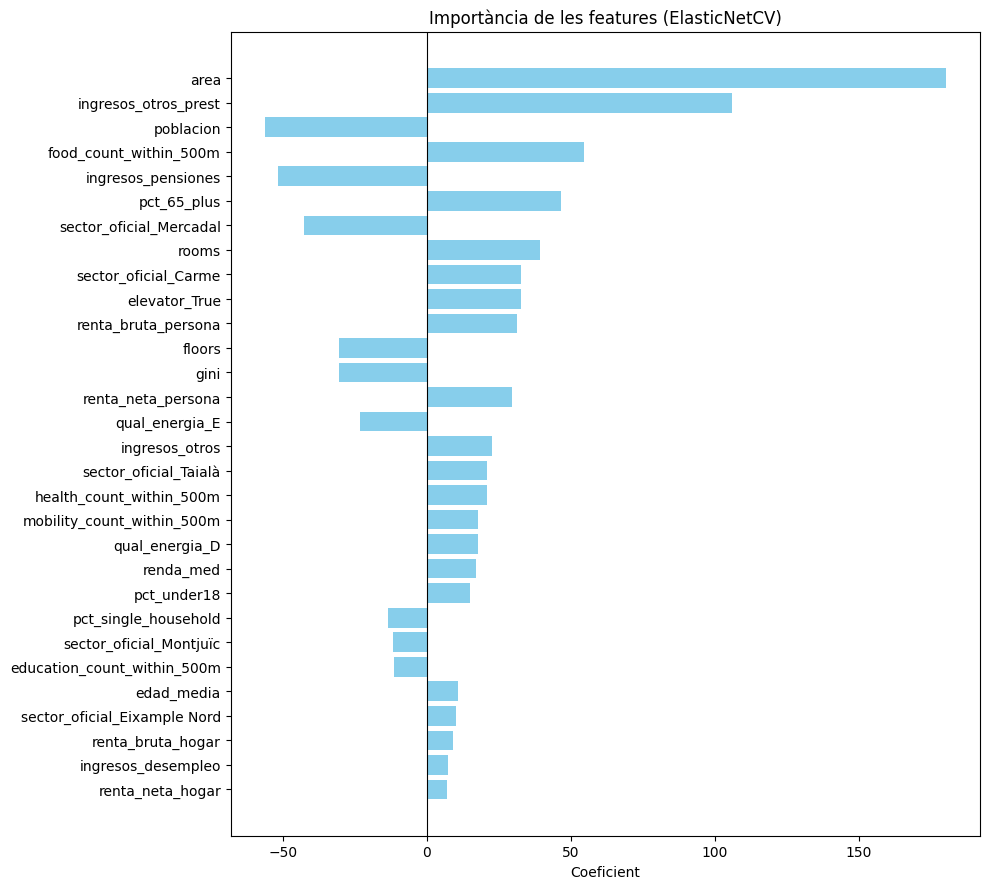

In [24]:
def plot_elasticnet_coefs(pipeline, top_n=30):
    """
    Mostra un bar plot horitzontal amb els coeficients absoluts de l'ElasticNet
    dins un pipeline amb ColumnTransformer i possibles OneHotEncoders.
    
    Args:
        pipeline : Pipeline entrenat amb un step 'regressor' ElasticNetCV
        top_n : int, nombre de features més importants a mostrar
    """
    # Extraiem el model i preprocessor
    elastic_model = pipeline.named_steps['regressor']
    preproc = pipeline.named_steps['preproc']

    # Noms de features transformades
    feature_names = []
    for name, transformer, cols in preproc.transformers_:
        if name != 'remainder':
            if isinstance(transformer, Pipeline):
                last_step = transformer.steps[-1][1]
            else:
                last_step = transformer

            if isinstance(last_step, OneHotEncoder):
                cats = last_step.get_feature_names_out(cols)
                feature_names.extend(cats)
            else:
                feature_names.extend(cols)

    # Coeficients
    coefs = elastic_model.coef_

    # DataFrame per ordenar
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coef': coefs
    })
    coef_df['abs_coef'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=True).tail(top_n)

    # Plot
    plt.figure(figsize=(10, max(6, 0.3*top_n)))
    plt.barh(coef_df['feature'], coef_df['coef'], color='skyblue')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.xlabel("Coeficient")
    plt.title("Importància de les features (ElasticNetCV)")
    plt.tight_layout()
    plt.show()

# Exemple d'ús:
plot_elasticnet_coefs(model, top_n=30)


# Predictions (Sector Level)

In [25]:
sectors = data["sector_oficial"].unique()
barri_mapping = data.set_index("sector_oficial")["barri_oficial"].to_dict()

defaults= {
    "rooms": 1,
    "floors": 0,
    "area": 25,
    "metres_cadastre": 28,
    "emissions_de_co2": 90,
    "renda_med": 15000,
    "gini": 38,
    "pct_65_plus": 25,
    "pct_under18": 25,
    "pct_single_household": 45,
    "ingresos_otros_prest": 0,
    "ingresos_otros": 0,
    "ingresos_pensiones": 0,
    "ingresos_desempleo": 0,
    "ingresos_salario": 8000,
    "renta_bruta_hogar": 16000,
    "renta_bruta_persona": 8000,
    "renta_neta_hogar": 14500,
    "renta_neta_persona": 7250,
    "edad_media": 48,
    "poblacion": 1000,
    "pct_espanola": 65,
    "tamany_mitja_hogar": 1.8,
    "education_count_within_500m": 0,
    "food_count_within_500m": 0,
    "health_count_within_500m": 0,
    "mobility_count_within_500m": 0,
    "public_service_count_within_500m": 0,
    "cost_energia": 5,
    "elevator": False,
    "qual_energia": "G",
    "year_available": 2026
}






pred_rows = []
for sector in sectors:
    row = defaults.copy()
    row["sector_oficial"] = sector
    row["year_available"] = 2026  
    row["barri_oficial"] = barri_mapping.get(sector, "Unknown")
    pred_rows.append(row)

X_pred = pd.DataFrame(pred_rows)
predicted_prices = model.predict(X_pred)

df_pred = X_pred.copy()
df_pred["predicted_price"] = predicted_prices

In [26]:
results_file = os.path.join(results_dir, "prediccions_sectors_2026.csv")

df_pred[["barri_oficial","sector_oficial","predicted_price"]].to_csv(results_file, index=False)
print(f"✔ Prediccions guardades a: prediccions_sectors_2026.csv")

✔ Prediccions guardades a: prediccions_sectors_2026.csv
